# Preparação do ambiente

## Bibliotecas

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import time
import unidecode
import warnings 

from joblib import dump, load

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from os import path as osp

from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

from string import punctuation

from tabulate import tabulate

from wordcloud import WordCloud

In [2]:
# Settings the warnings to be ignored 
warnings.filterwarnings('ignore')

start_time = time.time()

## Constantes e funções auxiliares

In [3]:
NULL_STRING = '#NULLO#'

In [4]:
def tokenizer(doc):
    doc = doc.lower()
    doc = unidecode.unidecode(doc)
    
    # uniformizar termos
    patterns = [('wi\s?.?fi', 'wifi'), 
                ('2,4', '2.4'), 
                ('5,8', '5.8')]
    for pattern, repl in patterns:
        doc = re.sub(pattern, repl, doc)
    
    stop_words = stopwords.words('portuguese')
    stop_words.extend(stopwords.words('english'))
    stop_words.extend(list(punctuation))
    # stopwords específicas do domínio
    stop_words.extend(['cm', 'feature', 'features', 'informações', 'itens', 'leve', 'list', 'nulo', 'package', 'pacote', 'pacotes', 'recurso', 'tamanho', 'ver', 'unidades', 'fio', 'universal'])
    # cores mais comumns
    stop_words.extend(['preto', 'cinza', 'branco', 'rosa', 'vermelho', 'laranja', 'amarelo', 'verde', 'azul', 'roxo', 'marrom'])
    # remover da lista de stopwords a palavra sem para formar o bigrama "sem fio", que pode ser relevante para o domínio
    # stop_words.remove('sem') 
    
    tokens = [token for token in word_tokenize(doc) if token not in stop_words]
    return tokens

def doc_cleaner(doc):
    tokens = tokenizer(doc)
    return ' '.join(tokens) 

In [5]:
def plot_docs_matrix(docs_matrix, true_targets=None, predicted_targets=None, title=None):
    pca = TruncatedSVD(n_components=2)
    pca_matrix = pca.fit_transform(docs_matrix)
    scatter_x = pca_matrix[:, 0] # first principle component
    scatter_y = pca_matrix[:, 1] # second principle component
    
    if predicted_targets is None:
        fig,ax = plt.subplots(figsize=(6,5))
        if true_targets is not None:
            for group in np.unique(true_targets):
                ix = np.where(true_targets == group)
                ax.scatter(scatter_x[ix], scatter_y[ix], label=group, s=5)
                if title is None:
                    ax.set_title('Documentos por categoria\n(Real)')   
                else:
                    ax.set_title(title)
        else:
            ax.scatter(scatter_x, scatter_y, s=5)
            if title is None:
                ax.set_title('Documentos')
            else:
                ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])
        
    else:
        fig,axs = plt.subplots(1,2,figsize=(12,5))
        if true_targets is not None:
            for group in np.unique(true_targets):
                ix = np.where(true_targets == group)
                axs[0].scatter(scatter_x[ix], scatter_y[ix], label=group, s=5)
                if title is None:
                    axs[0].set_title('Documentos por categoria\n(Real)')   
                else:
                    axs[0].set_title(title)
        else:
            axs[0].scatter(scatter_x, scatter_y, s=5)
            if title is None:
                axs[0].set_title('Documentos')
            else:
                axs[0].set_title(title)
        
        for group in np.unique(predicted_targets):
            ix = np.where(predicted_targets == group)
            axs[1].scatter(scatter_x[ix], scatter_y[ix], label=group, s=5)
            axs[1].set_title('Agrupamento por categoria\n(Predição)')

        for ax in axs.flat:
            ax.set_xticks([])
            ax.set_yticks([])
        
    plt.show()

In [6]:
def plot_wordcloud(wc_docs,max_words=50,ax=None,title='Principais palavras'):

    if hasattr(wc_docs, '__iter__'):
        wc_docs = ' '.join(wc_docs)
   
    wc = WordCloud(max_words=max_words,height=300).generate(wc_docs)

    if ax is None:
        fig,ax = plt.subplots(figsize=(5,5))
        show_plt = True
    else: 
        show_plt = False
    
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(title)

    if show_plt:
        plt.show()

In [7]:
def print_elapsed_time(elapsed_time):
    if elapsed_time < 120:
        print('The time of execution of above program is : {:.0f} seconds'.format(elapsed_time))
    else: 
        minutes = elapsed_time//60
        seconds = elapsed_time%60
        print('The time of execution of above program is : {:.0f} minutes {:.0f} seconds'.format(minutes,seconds))

# Carga e prepação dos dados

In [8]:
file_magalu = '../datasets/magalu/raw/magalu.parquet.gzip'
file_magalu_reindexed = '../datasets/magalu/raw/magalu_redindexed.parquet.gzip'
magalu_dtype = {'Link': 'string', 'Palavra_Chave': 'string',
                'cat_0': 'string', 'cat_1': 'string', 'cat_2': 'string', 'cat_3': 'string', 'cat_4': 'string',
                'Marca': 'string',  'Modelo': 'string', 'Nome': 'string', 
                'EAN': 'string', 'Certificado_de_Homologação': 'string',
                'Preço': 'string', 'Avaliações': 'string', 'Nota': 'string',
                'Imagem': 'string', 'Características': 'string', 'Descrição': 'string', 'Imagens': 'string',
                'Vendedor': 'string', 'Data_Inclusão': 'string', 'Ativo': 'string', 'Preço_Original': 'string', 'Categoria': 'string'}

file_ml = '../datasets/mercado_livre/raw/ml.parquet.gzip'
file_ml_reindexed = '../datasets/mercado_livre/raw/ml_redindexed.parquet.gzip'
ml_dtype = {'Link': 'string',  'Categoria': 'string', 'Marca': 'string', 'Modelo': 'string', 'Nome': 'string', 
            'Certificado_de_Homologação': 'string', 'Palavra_Chave': 'string',  'Preço': 'string',
            'Avaliações': 'string', 'Nota': 'string', 'Imagem': 'string', 'Características': 'string',
            'Descrição': 'string',  'Imagens': 'string', 'Vendedor': 'string', 'Data_Inclusão': 'string',
            'Ativo': 'string',
            'cat_0': 'string', 'cat_1': 'string', 'cat_2': 'string', 'cat_3': 'string', 'cat_4': 'string', 'cat_5': 'string', 'cat_6': 'string',
            'Qtd_disponível': 'string', 'Qtd_vendidos': 'string', 'Estado': 'string', 'EAN': 'string'}

if osp.exists(file_magalu_reindexed):
    print(f'Read existing file {file_magalu_reindexed}.')
    df_magalu = pd.read_parquet(file_magalu_reindexed)
    
else:
    print(f'Read existing file {file_magalu}, redindex and save to new file {file_magalu_reindexed}')
    df_magalu = pd.read_parquet(file_magalu)
    df_magalu = df_magalu.astype('string')
    # fill na values with NULL_STRING
    df_magalu = df_magalu.fillna(NULL_STRING)
    # reindex
    df_magalu = df_magalu.reset_index(drop=True)
    # save to new file
    df_magalu.to_parquet(file_magalu_reindexed,compression='gzip')

if osp.exists(file_ml_reindexed):
    print(f'Read existing file {file_ml_reindexed}.')
    df_ml = pd.read_parquet(file_ml_reindexed)
    
else:
    print(f'Read existing file {file_ml}, redindex and save to new file {file_ml_reindexed}')
    df_ml = pd.read_parquet(file_ml)
    df_ml = df_ml.astype('string')
    # fill na values with NULL_STRING
    df_ml = df_ml.fillna(NULL_STRING)
    # reindex
    df_ml = df_ml.reset_index(drop=True)
    # save to new file
    df_ml.to_parquet(file_ml_reindexed,compression='gzip')


Read existing file ../datasets/magalu/raw/magalu.parquet.gzip, redindex and save to new file ../datasets/magalu/raw/magalu_redindexed.parquet.gzip
Read existing file ../datasets/mercado_livre/raw/ml.parquet.gzip, redindex and save to new file ../datasets/mercado_livre/raw/ml_redindexed.parquet.gzip


# Análise

## Magalu

### K-Means

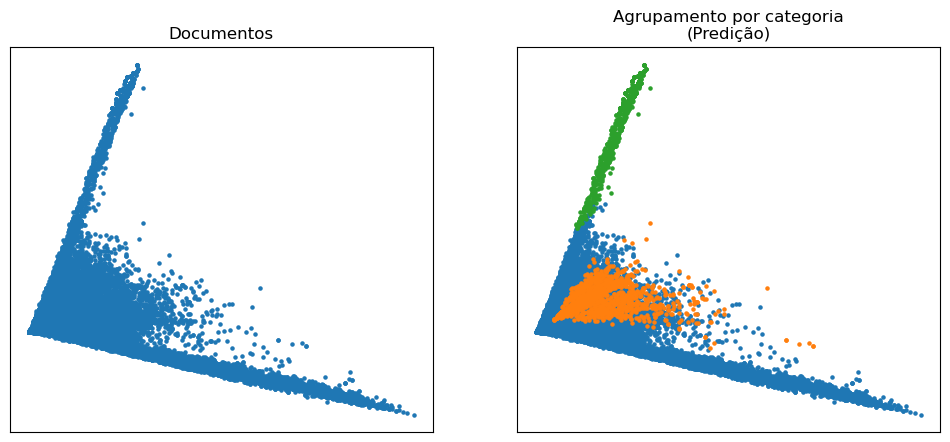

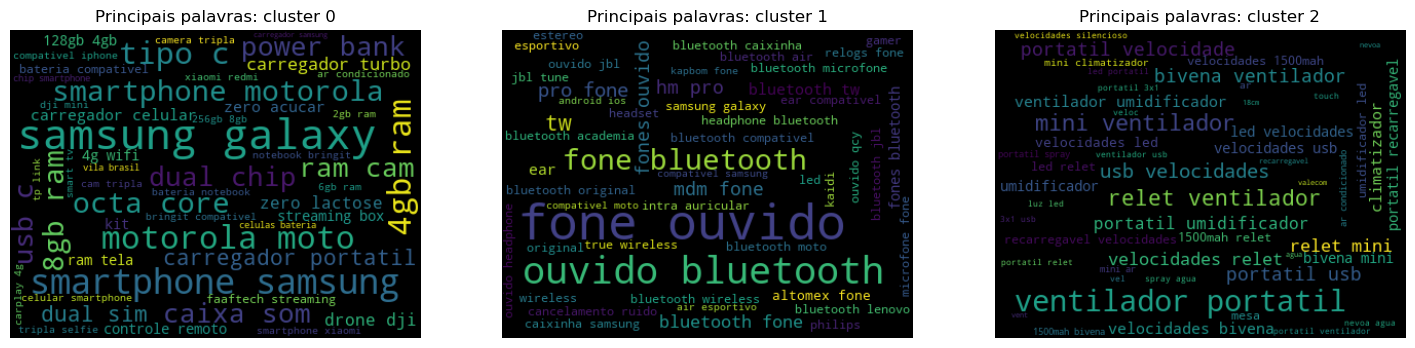

In [9]:
docs_magalu = df_magalu[df_magalu['Nome']!='Pedimos desculpas pela inconveniência...']['Nome'].drop_duplicates()
clean_docs_magalu = docs_magalu.map(doc_cleaner)
clean_docs_magalu = clean_docs_magalu.to_numpy()

vectorizer = TfidfVectorizer(tokenizer=tokenizer)
docs_matrix_magalu = vectorizer.fit_transform(clean_docs_magalu)

kmeans_magalu = KMeans(n_clusters=3, max_iter=500, n_init=1).fit(docs_matrix_magalu)
predicted_targets = kmeans_magalu.labels_
plot_docs_matrix(docs_matrix_magalu,predicted_targets=predicted_targets)

fig,axs = plt.subplots(1,3,figsize=(18,5))
for i,group in enumerate(np.unique(predicted_targets)):
    ix = np.where(predicted_targets==group)[0] 
    title = f'Principais palavras: cluster {i}'
    plot_wordcloud(clean_docs_magalu[ix],ax=axs[i],title=title)

### K-Means sem IDF

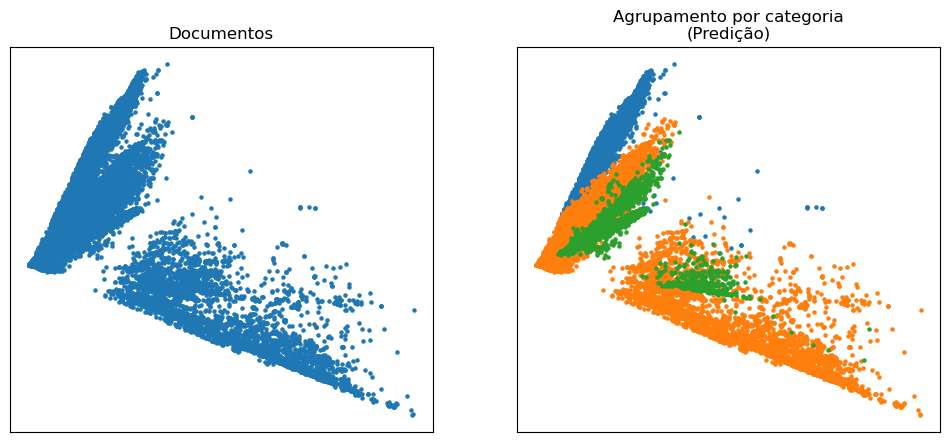

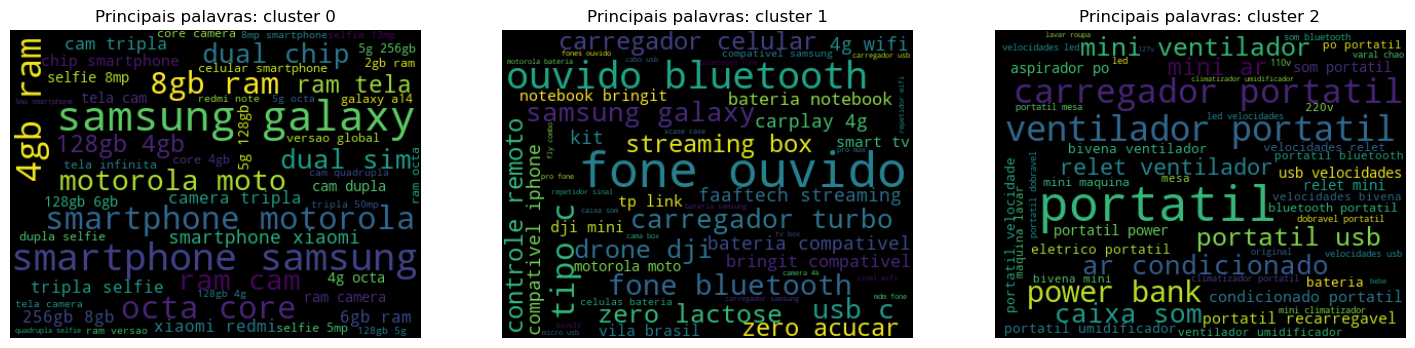

In [10]:
docs_magalu = df_magalu[df_magalu['Nome']!='Pedimos desculpas pela inconveniência...']['Nome'].drop_duplicates()
clean_docs_magalu = docs_magalu.map(doc_cleaner)
clean_docs_magalu = clean_docs_magalu.to_numpy()

vectorizer = TfidfVectorizer(tokenizer=tokenizer,use_idf=False)
docs_matrix_magalu = vectorizer.fit_transform(clean_docs_magalu)

kmeans_magalu = KMeans(n_clusters=3, max_iter=500, n_init=1).fit(docs_matrix_magalu)
predicted_targets = kmeans_magalu.labels_
plot_docs_matrix(docs_matrix_magalu,predicted_targets=predicted_targets)

fig,axs = plt.subplots(1,3,figsize=(18,5))
for i,group in enumerate(np.unique(predicted_targets)):
    ix = np.where(predicted_targets==group)[0] 
    title = f'Principais palavras: cluster {i}'
    plot_wordcloud(clean_docs_magalu[ix],ax=axs[i],title=title)

### Classificador Amazon

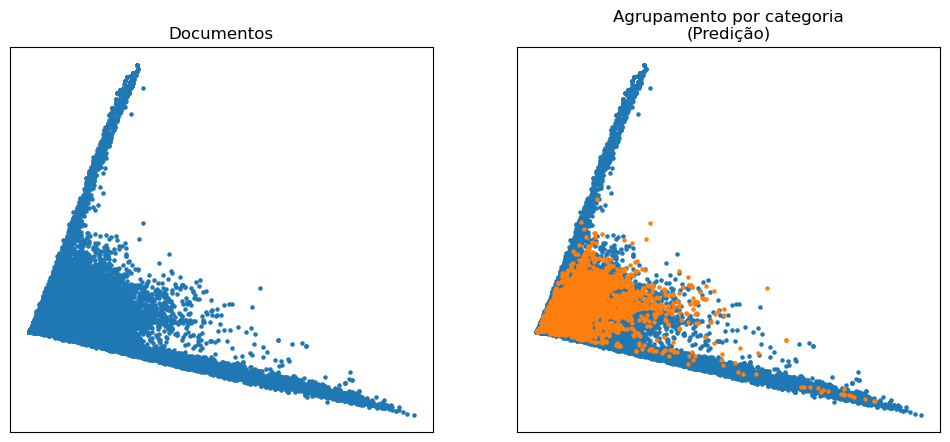

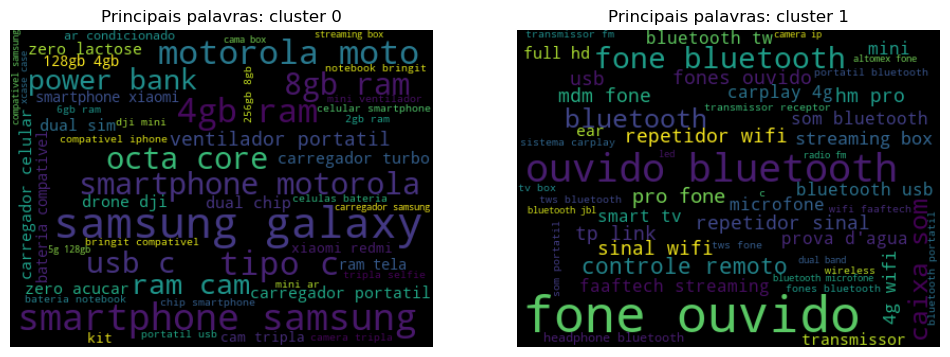

In [10]:
# load model
clf_sgd_telecom_rf = load('../models/pipe_sgd_telecom_rf.joblib') 
predicted_targets = clf_sgd_telecom_rf.predict(docs_magalu)

plot_docs_matrix(docs_matrix_magalu,predicted_targets=predicted_targets)

fig,axs = plt.subplots(1,2,figsize=(12,5))
for i,group in enumerate(np.unique(predicted_targets)):
    ix = np.where(predicted_targets==group)[0] 
    title = f'Principais palavras: cluster {i}'
    plot_wordcloud(clean_docs_magalu[ix],ax=axs[i],title=title)

## Mercado Livre

### K-Means

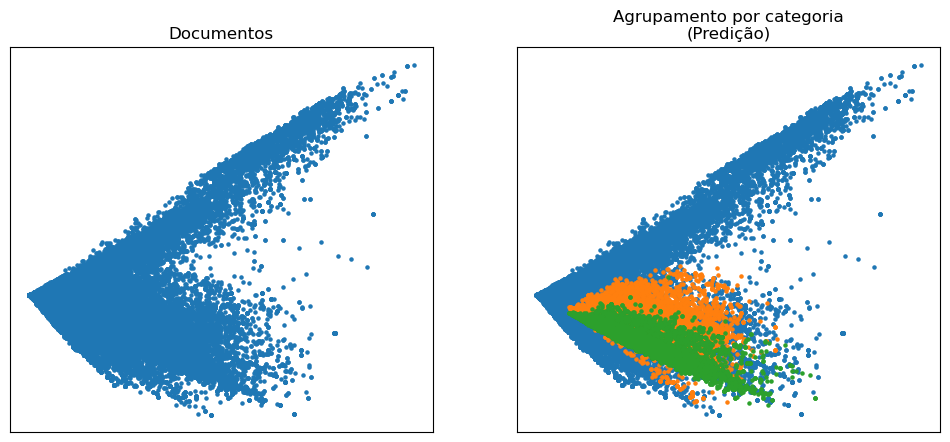

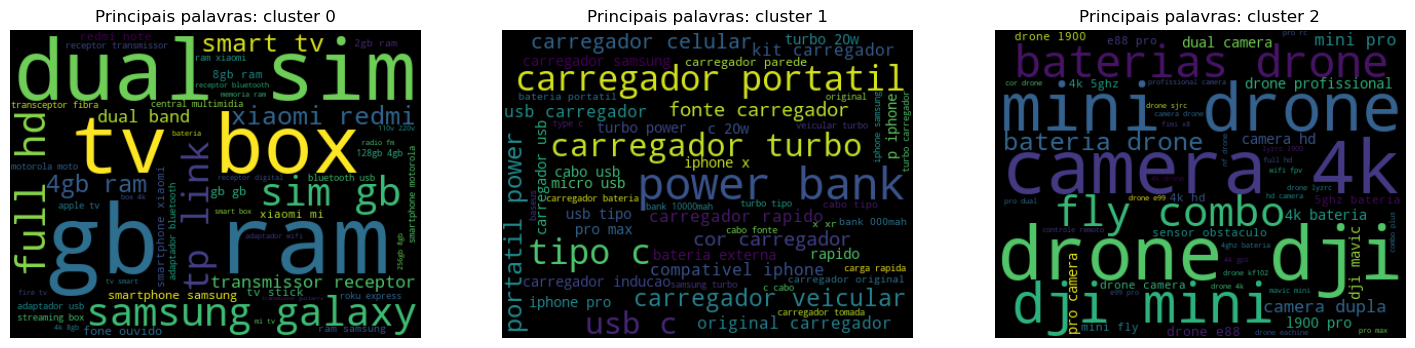

In [11]:
docs_ml = df_ml['Nome']
clean_docs_ml = docs_ml.map(doc_cleaner)
clean_docs_ml = clean_docs_ml.to_numpy()

vectorizer = TfidfVectorizer(tokenizer=tokenizer)
docs_matrix_ml = vectorizer.fit_transform(clean_docs_ml)

kmeans_ml = KMeans(n_clusters=3, max_iter=1500, n_init=1).fit(docs_matrix_ml)
predicted_targets = kmeans_ml.labels_
plot_docs_matrix(docs_matrix_ml,predicted_targets=predicted_targets)

fig,axs = plt.subplots(1,3,figsize=(18,5))
for i,group in enumerate(np.unique(predicted_targets)):
    ix = np.where(predicted_targets==group)[0] 
    title = f'Principais palavras: cluster {i}'
    plot_wordcloud(clean_docs_ml[ix],ax=axs[i],title=title)

### Classificador Amazon

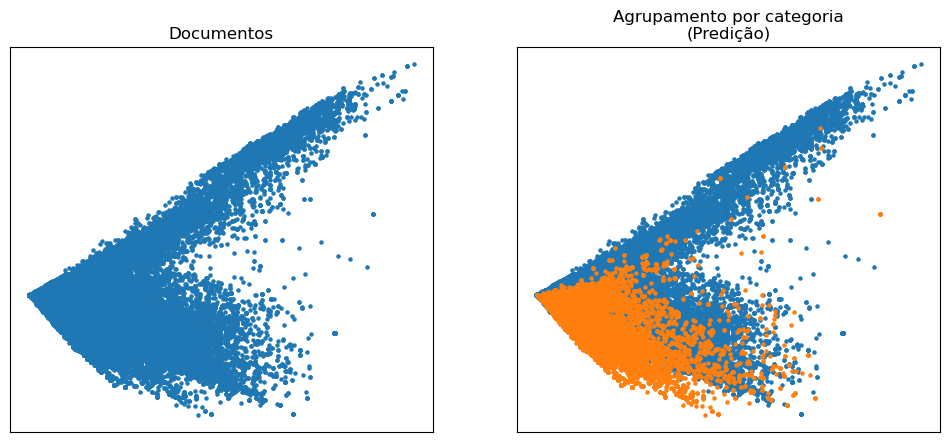

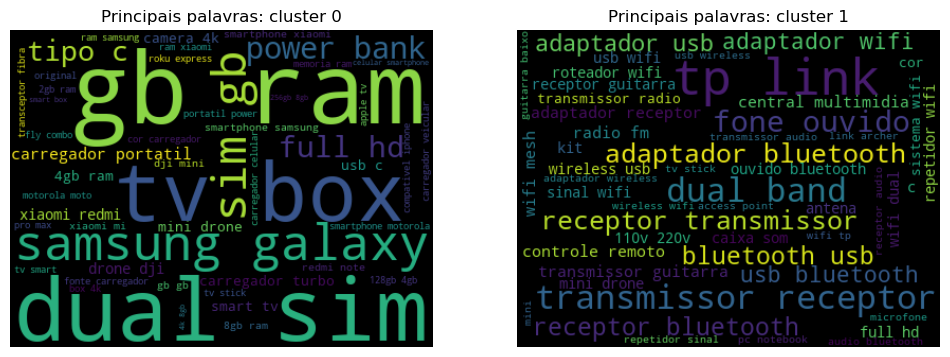

In [12]:
predicted_targets = clf_sgd_telecom_rf.predict(docs_ml)

plot_docs_matrix(docs_matrix_ml,predicted_targets=predicted_targets)

fig,axs = plt.subplots(1,2,figsize=(12,5))
for i,group in enumerate(np.unique(predicted_targets)):
    ix = np.where(predicted_targets==group)[0] 
    title = f'Principais palavras: cluster {i}'
    plot_wordcloud(clean_docs_ml[ix],ax=axs[i],title=title)

# Conclusão

Nesta análise, observou-se que a aplicação do classificador desenvolvido com os dados da Amazon nos conjuntos de dados extraídos de Magalu e Mercado Livre resultou em algum acerto, contudo, para que um classificador seja eficaz será necessária a rotulagem de mais dados para posterior treinamento de um classificador.

In [13]:
elapsed_time = time.time() - start_time
print_elapsed_time(elapsed_time)

The time of execution of above program is : 16 minutes 17 seconds
